
🔎 STEP COUNT EXPLORATION RESULTS
 Steps  Optimal p  Min Avg Cost
    10   4.934228     67.849208
    11   4.971465     67.844261
    12   4.827796     68.045863
    13   4.908092     68.059635
    14   4.941847     68.052033
    15   4.934228     68.064908
    16   4.816046     68.166984
    17   4.949068     68.071440
    18   4.891220     68.201872
    19   4.899394     68.166099
    20   4.827796     68.227599
✅ Optimal Steps: 11, p = 4.971, Min Avg Cost = ₹67.844


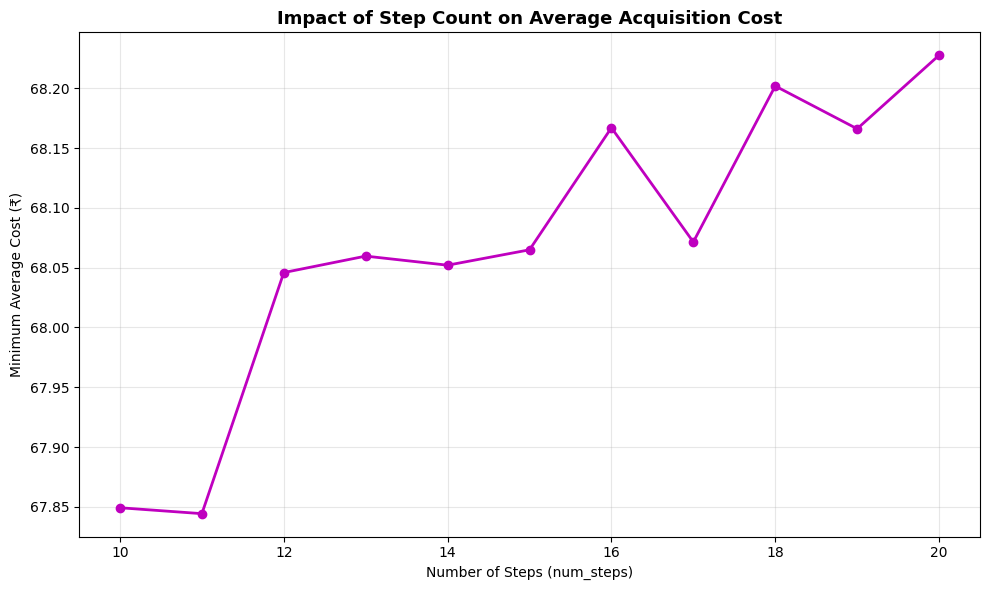


💹 OPTIMIZED RUPEE-COST-AVERAGING STRATEGY
 Step  Price (₹)  Investment (₹)  Quantity  Actual Invested (₹)  Cumulative Qty  Average Cost (₹)
    1      85.43         1020.71        11               939.73              11            85.430
    2      82.58         1208.45        14              1156.08              25            83.833
    3      79.82         1430.72        17              1356.94              42            82.208
    4      77.15         1693.86        21              1620.25              63            80.524
    5      74.58         2005.41        26              1939.04              89            78.787
    6      72.09         2374.27        32              2306.82             121            77.015
    7      69.68         2810.96        40              2787.24             161            75.193
    8      67.35         3327.98        49              3300.36             210            73.364
    9      65.11         3940.09        60              3906.32            

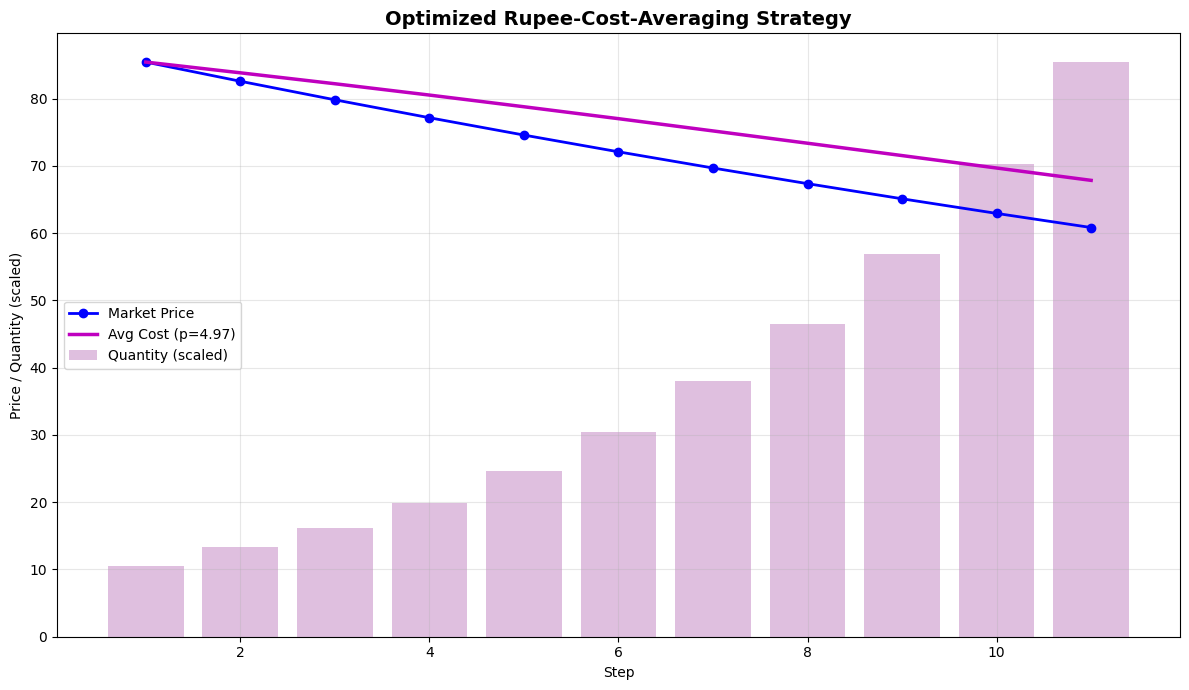

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar


# =====================================================
# 1️⃣ COMPUTATION MODULE
# =====================================================
def simulate_dca(prices, total_investment, p):
    """Simulate Rupee-Cost-Averaging with weighting proportional to (1/price)^p."""
    weights = (1 / prices) ** p
    weights /= np.sum(weights)

    investments = total_investment * weights
    quantities = np.floor(investments / prices).astype(int)
    actual_investments = quantities * prices

    cumulative_qty = np.cumsum(quantities)
    cumulative_investment = np.cumsum(actual_investments)
    avg_cost = cumulative_investment / np.maximum(cumulative_qty, 1)

    df = pd.DataFrame(
        {
            "Step": np.arange(1, len(prices) + 1),
            "Price (₹)": np.round(prices, 2),
            "Investment (₹)": np.round(investments, 2),
            "Quantity": quantities,
            "Actual Invested (₹)": np.round(actual_investments, 2),
            "Cumulative Qty": cumulative_qty,
            "Average Cost (₹)": np.round(avg_cost, 3),
        }
    )

    # TODO REFACTOR IT INTO A SEPARATE FUNCTION
    action = "create"
    orders_count = len(prices)
    tradingsymbol = "GOLDBEES"
    exchange = "NSE"
    transaction_type = "BUY"
    products = "CNC"
    order_type = "LIMIT"
    validity = "DAY"
    notes = "Created by Python Program"

    bulk_gtt_orders = {
        "action": np.full(orders_count, action),
        "gtt_id": np.full(orders_count, ""),
        "tradingsymbol": np.full(orders_count, tradingsymbol),
        "exchange": np.full(orders_count, exchange),
        "transaction_type": np.full(orders_count, transaction_type),
        "quantity": quantities,
        "trigger_price": np.round(prices + 0.10, 2),
        "order_price": np.round(prices, 2),
        "product": np.full(orders_count, products),
        "order_type": np.full(orders_count, order_type),
        "validity": np.full(orders_count, validity),
        "last_price": np.round(prices * 1.1, 2),
        "notes": np.full(orders_count, notes),
    }

    # TODO pass file path, and file name through CONSTANT
    pd.DataFrame(bulk_gtt_orders).to_csv(
        "./kite-trader/bulk-gtt-orders.csv", index=False
    )
    # TODO REFACTOR IT INTO A SEPARATE FUNCTION

    return df, cumulative_qty[-1], cumulative_investment[-1], avg_cost[-1]


# =====================================================
# 2️⃣ OPTIMIZATION MODULE
# =====================================================
def find_optimal_p(
    prices, total_investment, current_qty=0, current_avg_cost=0, bounds=(0, 5)
):
    """
    Find the exponent p minimizing blended average cost.
    If current holdings exist, optimization minimizes final blended cost.
    """

    def blended_avg_cost_for_p(p):
        _, new_qty, new_spent, _ = simulate_dca(prices, total_investment, p)
        total_qty = current_qty + new_qty
        total_spent = (current_qty * current_avg_cost) + new_spent
        return (total_spent / total_qty) if total_qty > 0 else np.inf

    result = minimize_scalar(blended_avg_cost_for_p, bounds=bounds, method="bounded")
    return result.x, result.fun


# =====================================================
# 3️⃣ OPTIMIZE OVER STEP COUNTS
# =====================================================
def find_optimal_steps(
    initial_price,
    final_price,
    total_investment,
    step_candidates,
    current_qty=0,
    current_avg_cost=0,
):
    """Try multiple num_steps and return configuration yielding lowest blended average cost."""
    records = []
    for num_steps in step_candidates:
        prices = np.geomspace(initial_price, final_price, num_steps)
        opt_p, blended_cost = find_optimal_p(
            prices, total_investment, current_qty, current_avg_cost
        )
        records.append((num_steps, opt_p, blended_cost))
    df_results = pd.DataFrame(records, columns=["Steps", "Optimal p", "Min Avg Cost"])
    best_row = df_results.loc[df_results["Min Avg Cost"].idxmin()]
    return best_row, df_results


# =====================================================
# 4️⃣ PLOTTING + REPORTING
# =====================================================
def plot_and_report(
    df,
    prices,
    total_qty,
    total_spent,
    final_price,
    opt_p,
    min_avg_cost,
    target_sell_price,
    current_qty=0,
    current_avg_cost=0,
):
    """Generate visualizations and report."""
    cumulative_qty = df["Cumulative Qty"].values
    avg_cost = df["Average Cost (₹)"].values
    steps = df["Step"].values

    # Combine old + new holdings if present
    if current_qty > 0:
        old_value = current_qty * current_avg_cost
        new_qty, new_spent = (
            df["Cumulative Qty"].iloc[-1],
            df["Actual Invested (₹)"].sum(),
        )
        total_qty = current_qty + new_qty
        total_spent = old_value + new_spent
        blended_avg_cost = total_spent / total_qty
    else:
        blended_avg_cost = min_avg_cost

    # === Reporting ===
    print("\n💹 OPTIMIZED RUPEE-COST-AVERAGING STRATEGY")
    print("=" * 90)
    print(df.to_string(index=False))
    print("=" * 90)

    if current_qty > 0:
        print(f"Existing Holdings: {current_qty} @ ₹{current_avg_cost:.2f}")
        print(
            f"Blended Average Cost: ₹{blended_avg_cost:.3f} "
            f"({((current_avg_cost - blended_avg_cost)/current_avg_cost)*100:+.2f}% improvement)"
        )
    print(f"Optimal weighting exponent (p): {opt_p:.3f}")
    print(f"Minimum achievable average cost (DCA only): ₹{min_avg_cost:.3f}")
    print(f"Total Quantity (combined): {total_qty}")
    print(f"Total Invested (combined): ₹{total_spent:,.2f}")

    final_value = total_qty * final_price
    profit_loss = final_value - total_spent
    profit_loss_pct = (profit_loss / total_spent) * 100
    print(f"Final Price: ₹{final_price:.2f}")
    print(f"Final Portfolio Value: ₹{final_value:,.2f}")
    print(f"P&L at Final Price: ₹{profit_loss:,.2f} ({profit_loss_pct:+.2f}%)")
    print("=" * 90)

    # === Target Simulation ===
    target_portfolio_value = total_qty * target_sell_price
    target_profit_loss = target_portfolio_value - total_spent
    target_profit_loss_pct = (target_profit_loss / total_spent) * 100
    print("\n🎯 TARGET SELL SIMULATION")
    print("=" * 90)
    print(f"Target Sell Price: ₹{target_sell_price:.2f}")
    print(f"Portfolio Value at Target: ₹{target_portfolio_value:,.2f}")
    print(
        f"Expected Profit/Loss: ₹{target_profit_loss:,.2f} ({target_profit_loss_pct:+.2f}%)"
    )
    print("=" * 90)

    # === Plot ===
    plt.figure(figsize=(12, 7))
    plt.plot(steps, prices, "bo-", linewidth=2, label="Market Price")
    plt.plot(steps, avg_cost, "m-", linewidth=2.5, label=f"Avg Cost (p={opt_p:.2f})")
    plt.bar(
        steps,
        df["Quantity"] * (max(prices) / max(df["Quantity"])),
        color="purple",
        alpha=0.25,
        label="Quantity (scaled)",
    )
    plt.title("Optimized Rupee-Cost-Averaging Strategy", fontsize=14, weight="bold")
    plt.xlabel("Step")
    plt.ylabel("Price / Quantity (scaled)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


# =====================================================
# 5️⃣ MAIN FUNCTION
# =====================================================
def main():
    # === User Inputs ===
    total_investment = 30000  # total budget (includes old holdings)
    current_qty = 0  # set > 0 to enable blended optimization
    current_avg_cost = 0

    initial_price = 85.43
    final_price = 60.83
    target_sell_price = 108.69

    # The number of steps/installments under which you wish to buy
    minimum_steps = 10
    maximum_steps = 20

    step_candidates = range(minimum_steps, maximum_steps + 1, 1)

    # Compute remaining investable amount if holdings exist
    invested_value = current_qty * current_avg_cost
    remaining_investment = max(total_investment - invested_value, 0)

    # === Optimization over step counts ===
    best_cfg, df_summary = find_optimal_steps(
        initial_price,
        final_price,
        remaining_investment,
        step_candidates,
        current_qty,
        current_avg_cost,
    )

    # === Show tabular summary ===
    print("\n🔎 STEP COUNT EXPLORATION RESULTS")
    print("=" * 60)
    print(df_summary.to_string(index=False))
    print("=" * 60)
    print(
        f"✅ Optimal Steps: {int(best_cfg['Steps'])}, p = {best_cfg['Optimal p']:.3f}, "
        f"Min Avg Cost = ₹{best_cfg['Min Avg Cost']:.3f}"
    )

    # === Chart: Avg Cost vs. Steps ===
    plt.figure(figsize=(10, 6))
    plt.plot(df_summary["Steps"], df_summary["Min Avg Cost"], "o-m", linewidth=2)
    plt.title(
        "Impact of Step Count on Average Acquisition Cost", fontsize=13, weight="bold"
    )
    plt.xlabel("Number of Steps (num_steps)")
    plt.ylabel("Minimum Average Cost (₹)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # === Final Simulation with best configuration ===
    prices = np.geomspace(initial_price, final_price, int(best_cfg["Steps"]))
    opt_p = best_cfg["Optimal p"]
    df, total_qty_new, total_spent_new, min_avg_cost = simulate_dca(
        prices, remaining_investment, opt_p
    )

    # === Reporting & Plotting ===
    plot_and_report(
        df,
        prices,
        total_qty_new,
        total_spent_new,
        final_price,
        opt_p,
        min_avg_cost,
        target_sell_price,
        current_qty,
        current_avg_cost,
    )


# =====================================================
# ENTRY POINT
# =====================================================
if __name__ == "__main__":
    main()